<a href="https://colab.research.google.com/github/Mhammad-riyaz/Character-level-lang-model-mlp2/blob/main/clm_mlp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("names.txt").read().splitlines()
print(words[:8])
block_size = 3
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['<S>'] = 0
stoi['<E>'] = 27
itos = {i:s for s,i in stoi.items()}
print(itos)
vocab_size = len(itos)
print(vocab_size)

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '<S>', 27: '<E>'}
28


In [3]:
 # build the dataset
def build_dataset(words):
  X,Y = [],[]
  for w in words:
    # print(w)
    context = [0] * block_size
    for ch in list(w)+['<E>']:
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->',itos[ix])
      context = context[1:] + [ix]
      # print(context)
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape,Y.shape)
  return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))  # 80% of the words
n2 = int(0.9 * len(words))  # 90% of the words

Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [4]:
n_embd = 10 # the dim of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer

g = torch.Generator().manual_seed(213)
C = torch.randn((vocab_size,n_embd),generator=g)
W1 = torch.randn((n_embd*block_size,n_hidden), generator=g) # mul with block size because, the input will include the contect of block size
b1 = torch.randn(n_hidden,generator=g)
W2 = torch.randn((n_hidden,vocab_size),generator=g)
b2 = torch.randn(vocab_size,generator=g)

parameters = [C,W1,b1,W2,b2]

print (sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

12108


In [5]:
max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):
  #mini-batch
  ix = torch.randint(0,Xtr.shape[0], (batch_size,) ,generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward_pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0],-1) # concatenate the vectore
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits,Yb) # loss function

  # backward_pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats

  if i%10000 == 0 :
    print(f'{i:7d}/{max_steps:7d} : {loss.item():.4f}')
  lossi.append(loss.log10().item())






      0/ 200000 : 26.2220
  10000/ 200000 : 2.1259
  20000/ 200000 : 2.6292
  30000/ 200000 : 2.4664
  40000/ 200000 : 2.2125
  50000/ 200000 : 2.1162
  60000/ 200000 : 2.5392
  70000/ 200000 : 2.9550
  80000/ 200000 : 2.6495
  90000/ 200000 : 2.3259
 100000/ 200000 : 2.0901
 110000/ 200000 : 2.1841
 120000/ 200000 : 2.1087
 130000/ 200000 : 1.7869
 140000/ 200000 : 1.9547
 150000/ 200000 : 2.5695
 160000/ 200000 : 1.8204
 170000/ 200000 : 2.3414
 180000/ 200000 : 1.8330
 190000/ 200000 : 2.0350


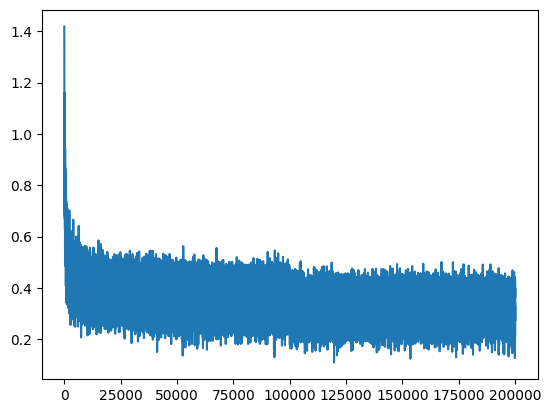

In [6]:
plt.plot(lossi)

In [7]:
@torch.no_grad() # this decorator disables gradient tracking which makes things efficient
def split_loss(split):
  x,y = {
      'train' : (Xtr,Ytr),
      'dev' : (Xdev,Ydev),
      'test' : (Xte,Yte)
  }[split]

  emb = C[x]
  embcat = emb.view(emb.shape[0],-1)
  h = torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits,y)
  print(split, loss.item())

split_loss("train")
split_loss("dev")



train 2.129178762435913
dev 2.1749355792999268


In [8]:
# sampling from the model
g = torch.Generator().manual_seed(123)
context = [0] * block_size
out = []
while True :
  emb = C[torch.tensor(context)]
  print(emb.shape)
  h = torch.tanh(emb.view(1,-1) @ W1 + b1)
  logits = h @ W2 + b2
  probs = F.softmax(logits,dim=1)

  ix = torch.multinomial(probs,num_samples=1,generator=g).item()
  context = context[1:] + [ix]
  out.append(ix)
  if ix == 27:
    break;
print(''.join(itos[i] for i in out))

torch.Size([3, 10])
torch.Size([3, 10])
torch.Size([3, 10])
torch.Size([3, 10])
torch.Size([3, 10])
torch.Size([3, 10])
torch.Size([3, 10])
avryje<E>


As we can see in the training the first iteration's loss is greater than 20, this is a very bad loss even though we are at the start of the optimization. How can we say that?, intially there are 27 characters, any character can come after one character, so it should be roughly like an uniform distribution but our initialization has so many problems that's why we are getting a huge loss at the starting


```
1/27.0 is the each chars probability
so the loss should be -(1/27.0).log() = -torch.tensor(1/27.0).log() = tensor(3.2958)
```

This is happening because due to random intialization of the numbers, if there are some extreme values in the logits, then the loss will be high because some character will take some high fake confidence etc.



In [9]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(213)
C = torch.randn((vocab_size,n_embd),generator=g)
W1 = torch.randn((n_embd*block_size,n_hidden), generator=g)
b1 = torch.randn(n_hidden,generator=g)
W2 = torch.randn((n_hidden,vocab_size),generator=g) * 0.01 # scaling down the values
b2 = torch.randn(vocab_size,generator=g) * 0  # removing all the bias

parameters = [C,W1,b1,W2,b2]

print (sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

12108


Now if we use the above code we will get the first iteration's loss near to the expected value. We can also observe that the plot is not anymore like hockey stick because there is no huge loss correction.

There is one more problem lurking in the intialization we have to address. If we break the intialization at the first iteration and print the h, we can see most of the values as 1

In [10]:
max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):
  #mini-batch
  ix = torch.randint(0,Xtr.shape[0], (batch_size,) ,generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward_pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0],-1) # concatenate the vectore
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits,Yb) # loss function

  # backward_pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats

  if i%10000 == 0 :
    print(f'{i:7d}/{max_steps:7d} : {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break





      0/ 200000 : 3.3130


In [11]:
h

tensor([[-0.3572,  1.0000, -1.0000,  ..., -0.9975,  1.0000, -0.9997],
        [-0.9527, -0.9735,  1.0000,  ...,  0.9952, -0.9986,  0.9799],
        [-0.3572,  1.0000, -1.0000,  ..., -0.9975,  1.0000, -0.9997],
        ...,
        [ 0.9909,  0.8205, -1.0000,  ...,  1.0000,  1.0000,  0.9899],
        [-0.9999, -1.0000, -1.0000,  ...,  0.9980, -0.9852,  1.0000],
        [ 0.9874, -0.9849, -1.0000,  ...,  0.9998,  1.0000,  0.9946]],
       grad_fn=<TanhBackward0>)

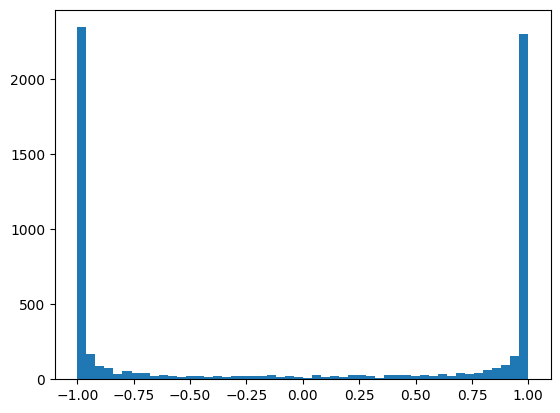

In [12]:
plt.hist(h.view(-1).tolist(), 50);

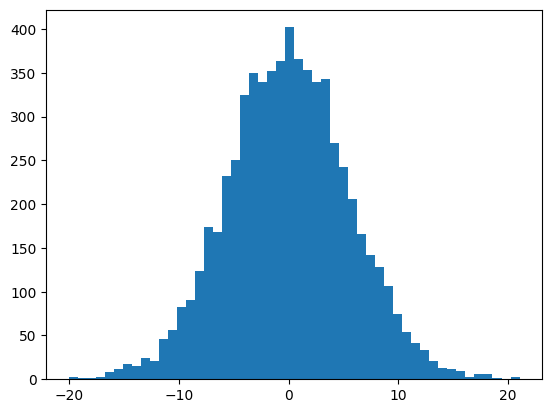

In [13]:
plt.hist(hpreact.view(-1).tolist(), 50);

The problem here is most of the values are are in the extreme ends of the tanh curve, the derivative of the tanh is (1-t**2) * out.grad (from micrograd).
So if the t is 1, then the first term becomes 0 and the out.grad doesn't matter what value it is, it gets destoryed and we are stopping the backpropagation through this tanh unit. And since the output of the tanh is in the tail area whatever input it is not going to impact the output of the tanh too much, so therefore no impact on the loss. And the weights and biases along with the tanh neuron do not impact the loss, we can be changing them whatever we want and the loss is not impacted.
But if the t is 0 then the tanh unit is sort of inactive, it becomes one and the gradient passes through.

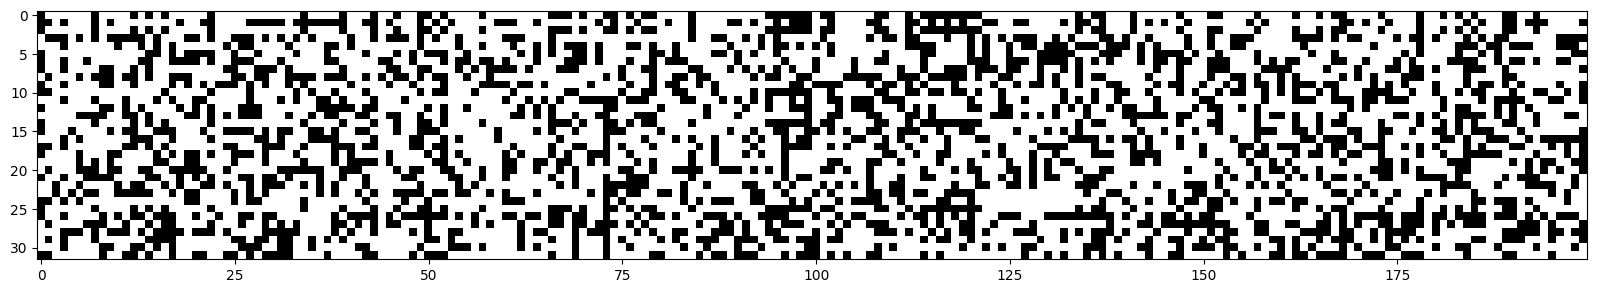

In [14]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray',interpolation="nearest") # it is a boolean tensor inside, so if it is true we get white, black other wise

As we can see in the above image, a lot of tanh neurons are very very active they are at the tails, so in all these cases , the backward gradient will get destroyed.
And We will be in more trouble if any of the column is fully white, it means it is a dead neuron and this neuron will never learn. So we have 200 neurons and 32 batch examples if any of the column is fully white, it means none of the examples are activating the tanh neuron.

In [15]:
# solving the above problem

n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(213)
C = torch.randn((vocab_size,n_embd),generator=g)
W1 = torch.randn((n_embd*block_size,n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size),generator=g) * 0.01 # scaling down the values
b2 = torch.randn(vocab_size,generator=g) * 0  # removing all the bias

parameters = [C,W1,b1,W2,b2]

print (sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

12108


In [16]:
max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):
  #mini-batch
  ix = torch.randint(0,Xtr.shape[0], (batch_size,) ,generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward_pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0],-1) # concatenate the vectore
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits,Yb) # loss function

  # backward_pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats

  if i%10000 == 0 :
    print(f'{i:7d}/{max_steps:7d} : {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break




      0/ 200000 : 3.3179


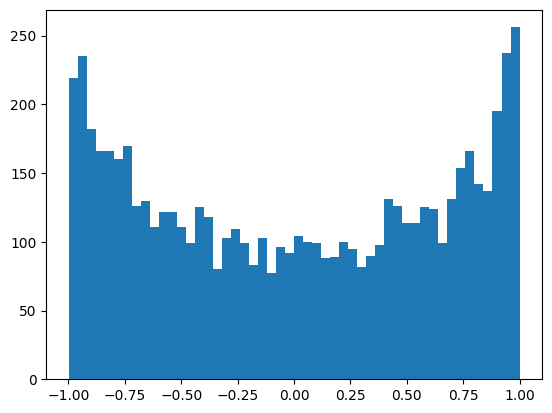

In [17]:
plt.hist(h.view(-1).tolist(), 50);

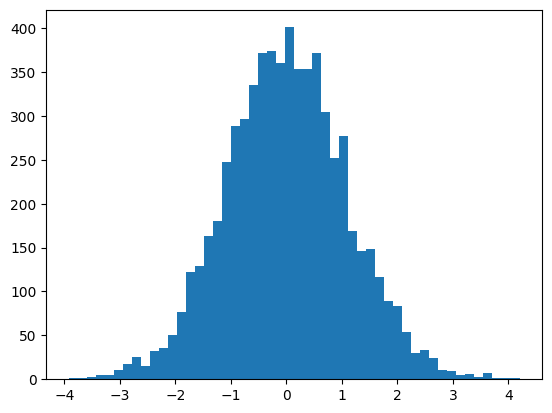

In [18]:
plt.hist(hpreact.view(-1).tolist(), 50);

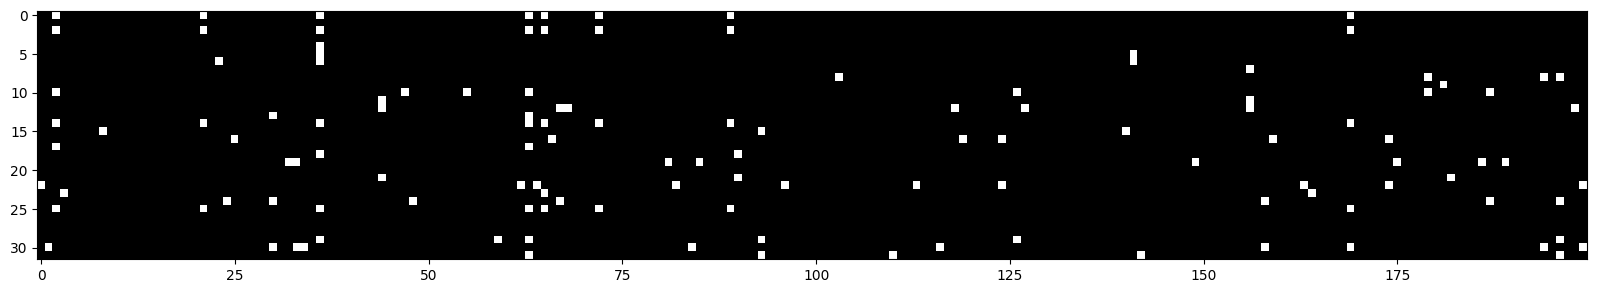

In [19]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray',interpolation="nearest") # it is a boolean tensor inside, so if it is true we get white, black other wise

In [20]:
max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):
  #mini-batch
  ix = torch.randint(0,Xtr.shape[0], (batch_size,) ,generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward_pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0],-1) # concatenate the vectore
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits,Yb) # loss function

  # backward_pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats

  if i%10000 == 0 :
    print(f'{i:7d}/{max_steps:7d} : {loss.item():.4f}')
  lossi.append(loss.log10().item())





      0/ 200000 : 3.2876
  10000/ 200000 : 2.3512
  20000/ 200000 : 2.2916
  30000/ 200000 : 1.9687
  40000/ 200000 : 2.4245
  50000/ 200000 : 2.3064
  60000/ 200000 : 2.0678
  70000/ 200000 : 1.9826
  80000/ 200000 : 2.1342
  90000/ 200000 : 1.6373
 100000/ 200000 : 2.4070
 110000/ 200000 : 1.8894
 120000/ 200000 : 2.1010
 130000/ 200000 : 2.7281
 140000/ 200000 : 1.8197
 150000/ 200000 : 1.9712
 160000/ 200000 : 2.3151
 170000/ 200000 : 2.0781
 180000/ 200000 : 1.8871
 190000/ 200000 : 2.0099


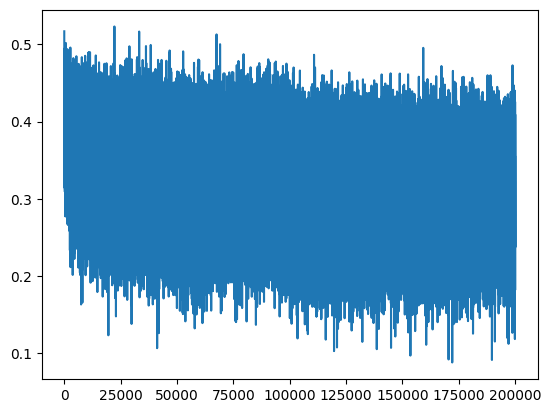

In [21]:
plt.plot(lossi)

In [22]:
@torch.no_grad() # this decorator disables gradient tracking which makes things efficient
def split_loss(split):
  x,y = {
      'train' : (Xtr,Ytr),
      'dev' : (Xdev,Ydev),
      'test' : (Xte,Yte)
  }[split]

  emb = C[x]
  embcat = emb.view(emb.shape[0],-1)
  h = torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits,y)
  print(split, loss.item())

split_loss("train")
split_loss("dev")



train 2.040541410446167
dev 2.102315902709961


In [23]:
# loss log
'''
# original loss
train 2.129178762435913
dev 2.1749355792999268

# fix softmax confidently wrong:
train 2.0728864669799805
dev 2.1346702575683594

# fix tanh layer too saturated at extremes at intialization:
train 2.040875196456909
dev 2.10288143157959
'''

'\n# original loss\ntrain 2.129178762435913\ndev 2.1749355792999268\n\n# fix softmax confidently wrong:\ntrain 2.0728864669799805\ndev 2.1346702575683594\n\n# fix tanh layer too saturated at extremes at intialization:\ntrain 2.040875196456909\ndev 2.10288143157959\n'

This is just one layer multi-layer perception so because the network is so shallow the optimization problem is actually quite easy and very forgiving so even though our initialization was terrible the network still learned
eventually it just got a bit worse result this is not the case in general though once we actually start working with much deeper networks that have say 50 layers things can get uh much more complicated and uh these problems stack
up and so you can actually get into a place where the network is basically not training at all if your initialization is bad enough and the deeper your network is and the more complex it is the less forgiving it is to some of these errors and so something to definitely be aware of and something to scrutinize something to plot and something to be careful with.

Now lets loot at how we got those number that we were multiplying in the intialization to the weights

tensor(-0.0100) tensor(1.0073)
tensor(0.0016) tensor(0.9846)


(array([2.15280608e-05, 0.00000000e+00, 2.15280608e-05, 2.15280608e-05,
        0.00000000e+00, 1.07640304e-04, 6.45841825e-05, 1.07640304e-04,
        2.36808669e-04, 5.59729582e-04, 7.53482130e-04, 1.85141323e-03,
        2.32503057e-03, 3.20768107e-03, 5.87716061e-03, 1.04841656e-02,
        1.44022727e-02, 2.48003261e-02, 3.90303743e-02, 5.75445066e-02,
        8.95352051e-02, 1.25250258e-01, 1.80405150e-01, 2.44989332e-01,
        3.14245104e-01, 3.73124351e-01, 4.19581906e-01, 4.32025125e-01,
        4.18010357e-01, 3.81757103e-01, 3.20940331e-01, 2.54031118e-01,
        1.87509410e-01, 1.38080982e-01, 9.22692688e-02, 6.22376239e-02,
        4.06449789e-02, 2.67378516e-02, 1.69641119e-02, 9.83832381e-03,
        6.65217080e-03, 3.68129840e-03, 2.21739027e-03, 1.65766069e-03,
        8.61122434e-04, 4.52089278e-04, 1.50696426e-04, 1.72224487e-04,
        8.61122434e-05, 8.61122434e-05]),
 array([-6.40186405, -6.16960904, -5.93735403, -5.70509902, -5.47284401,
        -5.240589  , 

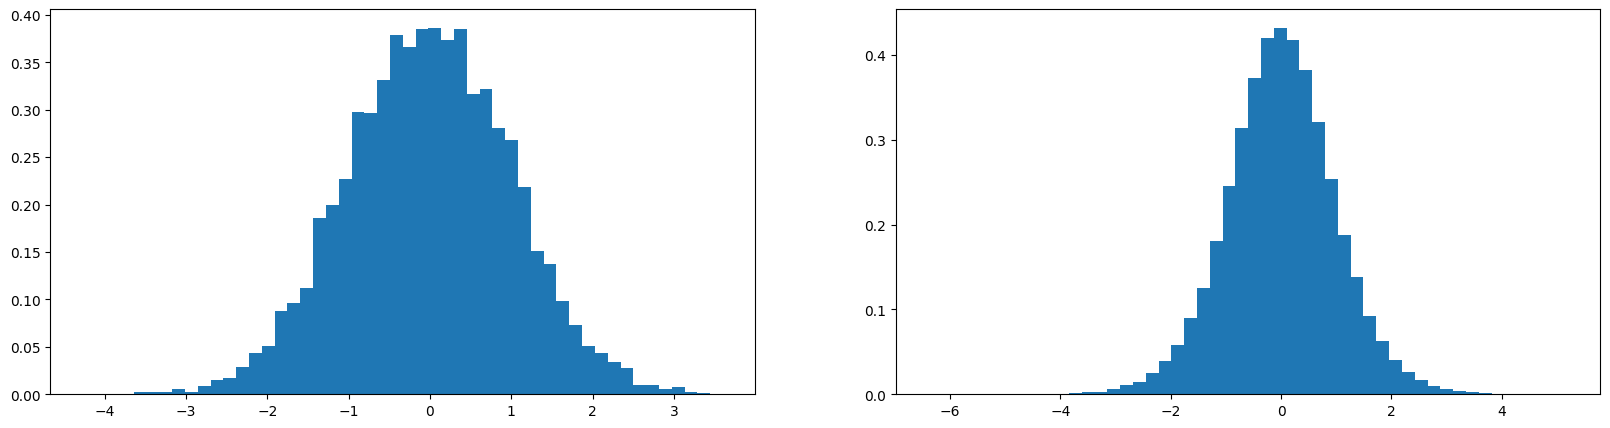

In [24]:
x = torch.randn(1000,10)
w = torch.randn (10,200) / 10 ** 0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)


As we can see in the above example that the Gaussian distribution of the x is with mean 0 and standard deviation of 1, but when we multiply it with w and plot the y the mean is 0 but the standard deviation is 3, the spread is increased (look at the x-axis values of the y plot) and we don't want that we want most of the neural net to have relatively similar activations so unit guassian roughly throughout the neural net.
So the question here is how do we scale the w's to preserve the y distrubtion to remain Gaussian.
If multiply the w's with some postive large number like 10 or 15, we can see that the spread is increasing, conversely if we mutliply with a relatively smaller number like 0.1 or 0.2 we can see the spread is shrinking.
So Now what is the value to multiply to exactly preserve the standard deviation to be 1.
For that we have to divide the weights with the square root of  number of inputs, in our case the inputs are 10.

So there a paper of Kaiming He where the researchers studies about the Relu activation unit, in Relu basically we clamp everything negative to 0, so we are destorying half of the distribution so they found out that this should be compensated with a gain that is square root of 'fan in', in pytorch there is alread this kaiming_normal method for intialization of the network params and they also found that regarding the gradients during the back-propagation if the acitivations in the forward pass are good it will be good enought for the back-propagation.
Another way to understand the reason for gain is by using Relu or tanh or sigmoid activation we are contracting and squeezing the values in order to compensate the squeezing we need boost the weights.

In [25]:
# Now lets adjust the weights intialization again by considering these


n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(213)
C = torch.randn((vocab_size,n_embd),generator=g)
W1 = torch.randn((n_embd*block_size,n_hidden), generator=g) * (5/3) / (n_embd*block_size ** 0.5) # 5/3 is the reward for tanh (refer pytorch for the rewards of activation functions)
b1 = torch.randn(n_hidden,generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size),generator=g) * 0.01
b2 = torch.randn(vocab_size,generator=g) * 0

parameters = [C,W1,b1,W2,b2]

print (sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

# Now try rerunning the backprop

12108


But nowdays the pricise setting of the intialization of the neural nets is not as important due to some modern day innovations, One of them is batch normalization.


Remember that we dont want the hpreact in our above code as too large then the tanh is saturated and at the same time we don't want them to be too small otherwise the tanh won't be doing anything, it will be inactive. we want them to be rougly Gaussian atleast at initialization.
The Insight from the Batch Normalization paper is, "you have these hidden States and you'd like them to be roughly Gaussian then why not take the hidden States and just normalize them to be Gaussian".

In [26]:
max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):
  #mini-batch
  ix = torch.randint(0,Xtr.shape[0], (batch_size,) ,generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward_pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0],-1)
  hpreact = embcat @ W1 + b1
  hpreact = hpreact - hpreact.mean(0,keepdim=True) / hpreact.std(0,keepdim=True)
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits,Yb)

  # backward_pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats

  if i%10000 == 0 :
    print(f'{i:7d}/{max_steps:7d} : {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000 : 3.3334
  10000/ 200000 : 2.1698
  20000/ 200000 : 2.3797
  30000/ 200000 : 2.1647
  40000/ 200000 : 1.9536
  50000/ 200000 : 1.9527
  60000/ 200000 : 2.3832
  70000/ 200000 : 2.7083
  80000/ 200000 : 2.5277
  90000/ 200000 : 2.2309
 100000/ 200000 : 1.8307
 110000/ 200000 : 2.1308
 120000/ 200000 : 2.0609
 130000/ 200000 : 1.7613
 140000/ 200000 : 1.9022
 150000/ 200000 : 2.5267
 160000/ 200000 : 1.6584
 170000/ 200000 : 2.1992
 180000/ 200000 : 1.7200
 190000/ 200000 : 1.9685


It is the standardization formula and (0,keepdim=True) means we are taking the mean,sd across the rows that is acorss all the 32 examples. And that's why it is called Batch normalization because we are normalizing the batch.
we can just train the nn but the problem is you actually
won't achieve a very good result with this and the reason for that
is we want these to be roughly Gaussain but only at initialization but we don't
want these be to be forced to be Gaussian always, we we'd like to allow the neural net to move around to potentially make it more diffuse to make it more sharp to make some neurons maybe be trigger happy or less trigger happy so we'd like this distribution to move around and we'd like the back propagation to tell us how the distribution should move around. So in addition to this idea of
standardizing the activations that any point in the network uh we have to also
introduce this additional component in the paper here described as scale and shift and so basically what we're doing is we're taking these normalized inputs and we are additionally scaling them by some gain and offsetting them by some
bias to get our final output from this layer.

In [27]:
# Now lets adjust the weights intialization again by considering these


n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(213)
C = torch.randn((vocab_size,n_embd),generator=g)
W1 = torch.randn((n_embd*block_size,n_hidden), generator=g) * (5/3) / (n_embd*block_size ** 0.5) # 5/3 is the reward for tanh (refer pytorch for the rewards of activation functions)
b1 = torch.randn(n_hidden,generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size),generator=g) * 0.01
b2 = torch.randn(vocab_size,generator=g) * 0

bngain = torch.ones((1,n_hidden)) # Batch normalization gain
bnbias = torch.zeros((1,n_hidden)) # Batch normalization bias

parameters = [C,W1,b1,W2,b2,bngain,bnbias] # adding teh bngain and bnbias to params

print (sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True



12508


In [28]:
max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):
  #mini-batch
  ix = torch.randint(0,Xtr.shape[0], (batch_size,) ,generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward_pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0],-1)
  hpreact = embcat @ W1 + b1
  hpreact = bngain *  hpreact - hpreact.mean(0,keepdim=True) / hpreact.std(0,keepdim=True) + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits,Yb)

  # backward_pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats

  if i%10000 == 0 :
    print(f'{i:7d}/{max_steps:7d} : {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000 : 3.3334
  10000/ 200000 : 2.1337
  20000/ 200000 : 2.3945
  30000/ 200000 : 2.2129
  40000/ 200000 : 1.9852
  50000/ 200000 : 1.9622
  60000/ 200000 : 2.4383
  70000/ 200000 : 2.7290
  80000/ 200000 : 2.5781
  90000/ 200000 : 2.0987
 100000/ 200000 : 1.8731
 110000/ 200000 : 2.1190
 120000/ 200000 : 2.0223
 130000/ 200000 : 1.7343
 140000/ 200000 : 1.9068
 150000/ 200000 : 2.5577
 160000/ 200000 : 1.7155
 170000/ 200000 : 2.2228
 180000/ 200000 : 1.7228
 190000/ 200000 : 1.9721


Now adding multiplying with the gain and adding the bias, no matter what during the intialization the distribution will be a unit Gaussian because we are multiplying with just ones and adding zeroes, and after the neural net will adjust the bngain and the bnbias according to how it wants.

In [29]:
# adding the normaliztion in the testing too
@torch.no_grad()
def split_loss(split):
  x,y = {
      'train' : (Xtr,Ytr),
      'dev' : (Xdev,Ydev),
      'test' : (Xte,Yte)
  }[split]

  emb = C[x]
  embcat = emb.view(emb.shape[0],-1)
  hpreact = embcat @ W1 + b1
  hpreact = bngain *  hpreact - hpreact.mean(0,keepdim=True) / hpreact.std(0,keepdim=True) + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits,y)
  print(split, loss.item())

split_loss("train")
split_loss("dev")



train 2.063821792602539
dev 2.114286422729492


In [30]:
# loss log
'''

# original loss
train 2.129178762435913
dev 2.1749355792999268

# fix softmax confidently wrong:
train 2.0728864669799805
dev 2.1346702575683594

# fix tanh layer too saturated at extremes at intialization:
train 2.040875196456909
dev 2.10288143157959

# batch normalization
train 2.063821792602539
dev 2.114286422729492
'''

'\n\n# original loss\ntrain 2.129178762435913\ndev 2.1749355792999268\n\n# fix softmax confidently wrong:\ntrain 2.0728864669799805\ndev 2.1346702575683594\n\n# fix tanh layer too saturated at extremes at intialization:\ntrain 2.040875196456909\ndev 2.10288143157959\n\n# batch normalization\ntrain 2.063821792602539\ndev 2.114286422729492\n'

We are not expecting better results here, because our neural net is very simple with one hidden layer, os we already achieved guassian distribution by solving the saturated tanh and the batch normalization is not doing anything here, but for a deep neural net with many hidden layers it will become very difficult to scale the weight matrices to be roughly Gaussian in that case Batch normalization will help a ton.

Batch Normalization actually comes at a terrible cost and that cost is that if you think about what's happening here something terribly strange and unnatural is happening it used to be that we have a single example feeding into a neural nut and then uh we calculate its activations and its loits and this is a
deterministic sort of process so you arrive at some logits for this example and then because of efficiency of training we suddenly started to use batches of examples but those batches of examples were processed independently
and it was just an efficiency thing but now suddenly in batch normalization because of the normalization through the batch we are coupling these examples mathematically and in the forward pass and the backward pass of a neural net so
now the hidden State activations hpreact in your logits for any one input
example are not just a function of that example but they're also a function of all the other examples that happen to come for a ride in that batch and these examples are sampled randomly and so what's happening is for example when you look at hpreact that's going to feed into H the hidden State activations
for any one of these input examples is going to actually change slightly depending on what other examples there are in a batch and it's going to like Jitter if you imagine sampling different examples because the the statistics of the mean and the standard deviation going to be impacted because the calculation of the means and SD includes all the examples in the batch and so you'll get a Jitter for h and you'll get a Jitter for
loits and you think that this would be a bug or something undesirable but in a
very strange way this actually turns out to be good in your Network training and
as a side effect and the reason for that is that you can think of this as kind of like a regularizer because what's happening is you have your input and you get your h and then depending on the other examples this is jittering a bit
and so what that does is that it's effectively padding out any one of these input examples and it's introducing a little bit of entropy and because of the padding out it's actually kind of like a form of a data augmentation it's kind of like augmenting the input a little bit and jittering it and that makes it
harder for the neural net to overfit to these concrete specific examples so by introducing all this noise it actually and this has made it harder for us to remove the use of batch normalization because basically no one likes this property that the the examples in the batch are coupled mathematically and in the forward pass and at least all kinds of like strange results we'll go into in a second as well and it leads to a lot of bugs and so on and no one likes this property and so people have tried to deprecate the use of batch normalization and move to other normalization techniques that do not couple the examples of a batch examples
some of them are layer normalization instance normalization group normalization and so on and we'll come some these later but basically long story short batch normalization was the first kind of normalization layer to be introduced it worked extremely well it happened to have this regularizing effect it stabilized training.

There is one more issue here that is in the evalution we are using calculating the mean and SD for a batch again but in a production environment usually a single example/input will be fed into the network there won't be a batch so to tackle this one of the suggested method in the paper is to calculate the mean and the standard deviation of the whole training set after the optimizaion/training of the neural net is done and fix those values.

In [31]:
# caliberate the batch norm at the end of the training
with torch.no_grad(): # telling that we won't calculate gradient on these for efficiency
 emb = C[Xtr]
 embcat = emb.view(emb.shape[0],-1)
 hpreact = embcat @ W1 + b1
 bnmean = hpreact.mean(0,keepdim=True)
 bnstd = hpreact.std(0,keepdim=True)

In [32]:
# adding the normaliztion in the testing too
@torch.no_grad()
def split_loss(split):
  x,y = {
      'train' : (Xtr,Ytr),
      'dev' : (Xdev,Ydev),
      'test' : (Xte,Yte)
  }[split]

  emb = C[x]
  embcat = emb.view(emb.shape[0],-1)
  hpreact = embcat @ W1 + b1
  hpreact = bngain *  (hpreact-bnmean) / bnstd + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits,y)
  print(split, loss.item())

split_loss("train")
split_loss("dev")



train 2.342331886291504
dev 2.3712852001190186


But nobody wants to do the mean and standard deviation calculation after the training everybody is lazy, there is another approach that is to estimate the means and std during the training process only, one thing is we can add plus epsillon (small number) in the denominator to the std to prevent divsion with a zero.
The other thing is we are adding the bias b1, but we are subtracting it out when we are removing the bnmeani from preact, so it better to remove the bias at the layers where we are doing linear operations, the bnbias will act as the bias and will be sufficient.
Adding it won't hurt the performance but it's just useless.

In [33]:
# Now lets adjust the weights intialization again by considering these


n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(213)
C = torch.randn((vocab_size,n_embd),generator=g)
W1 = torch.randn((n_embd*block_size,n_hidden), generator=g) * (5/3) / (n_embd*block_size ** 0.5) # 5/3 is the reward for tanh (refer pytorch for the rewards of activation functions)
b1 = torch.randn(n_hidden,generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size),generator=g) * 0.01
b2 = torch.randn(vocab_size,generator=g) * 0

bngain = torch.ones((1,n_hidden)) # Batch normalization gain
bnbias = torch.zeros((1,n_hidden)) # Batch normalization bias

bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

parameters = [C,W1,W2,b2,bngain,bnbias] # adding the bngain and bnbias to params

print (sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True



12308


In [34]:
max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):
  #mini-batch
  ix = torch.randint(0,Xtr.shape[0], (batch_size,) ,generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward_pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0],-1)

  # Linear Layer
  hpreact = embcat @ W1  # + b1

  # Batch Norm
  bnmeani = hpreact.mean(0,keepdim=True)
  bnstdi = hpreact.std(0,keepdim=True)
  hpreact = bngain *  hpreact - bnmeani / bnstdi  + bnbias

 # calculating mean and std estimate of the whole training dataset
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  # Non-linearity
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits,Yb)

  # backward_pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats

  if i%10000 == 0 :
    print(f'{i:7d}/{max_steps:7d} : {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000 : 3.3329
  10000/ 200000 : 2.1444
  20000/ 200000 : 2.4165
  30000/ 200000 : 2.2274
  40000/ 200000 : 2.0200
  50000/ 200000 : 1.9427
  60000/ 200000 : 2.4131
  70000/ 200000 : 2.7292
  80000/ 200000 : 2.5553
  90000/ 200000 : 2.1153
 100000/ 200000 : 1.8572
 110000/ 200000 : 2.0744
 120000/ 200000 : 2.1101
 130000/ 200000 : 1.7651
 140000/ 200000 : 1.9576
 150000/ 200000 : 2.5251
 160000/ 200000 : 1.8474
 170000/ 200000 : 2.2932
 180000/ 200000 : 1.6728
 190000/ 200000 : 2.0642


In [35]:
# adding the normaliztion in the testing too
@torch.no_grad()
def split_loss(split):
  x,y = {
      'train' : (Xtr,Ytr),
      'dev' : (Xdev,Ydev),
      'test' : (Xte,Yte)
  }[split]

  emb = C[x]
  embcat = emb.view(emb.shape[0],-1)
  hpreact = embcat @ W1 + b1
  hpreact = bngain *  (hpreact-bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits,y)
  print(split, loss.item())

split_loss("train")
split_loss("dev")



train 2.5280988216400146
dev 2.561215400695801


###Torchifying the code

In [61]:
# Let's train a deeper network

class Linear:

  def __init__ (self,fan_in,fan_out,bias=True):
    self.weight = torch.randn((fan_in,fan_out),generator=g) / fan_in**0.5 # fixing the staturated tanh with the first method (Kaiming He)
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self,x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out+=self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

  def __init__(self, dim,eps=1e-5,momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters trained with backprop
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with running momentum update)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__ (self,x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else :
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x-xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma,self.beta]

class Tanh:
  def __call__ (self,x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(123) # for reproducibility

C = torch.randn((vocab_size,n_embd), generator=g)
layers = [
    Linear(n_embd*block_size,n_hidden), Tanh(),
    Linear(n_hidden,n_hidden), Tanh(),
    Linear(n_hidden,n_hidden), Tanh(),
    Linear(n_hidden,n_hidden), Tanh(),
    Linear(n_hidden,n_hidden), Tanh(),
    Linear(n_hidden,vocab_size) ,
]
with torch.no_grad():
  # last layer: make less confident, as we saw above
  layers[-1].weight *= 0.1
  # all other layers : apply gain
  for layer in layers[:-1]:
    if isinstance(layer,Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) #  total number of parameters
for p in parameters:
  p.requires_grad = True


46608


In [37]:
# same optimization as last time

max_steps = 200_000
batch_size = 32
lossi= []
ud = []

for i in range(max_steps):

  # mini-batch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  x = emb.view(emb.shape[0],-1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x,Yb) # loss function


  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i%10000 == 0:
    print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
  lossi.append(loss.log10().item())

  with torch.no_grad():
    ud.append([(lr*p.grad.std() / p.data.std()).log10 ().item() for p in parameters ])

  if i > 1000:
    break










      0/ 200000:3.3525


layer 1 (      Tanh): mean -0.02, std 0.75, saturated: 18.56%
layer 3 (      Tanh): mean -0.01, std 0.71, saturated: 10.50%
layer 5 (      Tanh): mean -0.06, std 0.73, saturated: 11.78%
layer 7 (      Tanh): mean -0.01, std 0.74, saturated: 14.00%
layer 9 (      Tanh): mean +0.05, std 0.71, saturated: 10.53%


/tmp/ipython-input-676147350.py:8: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  print(f'layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))


Text(0.5, 1.0, 'activation distribution')

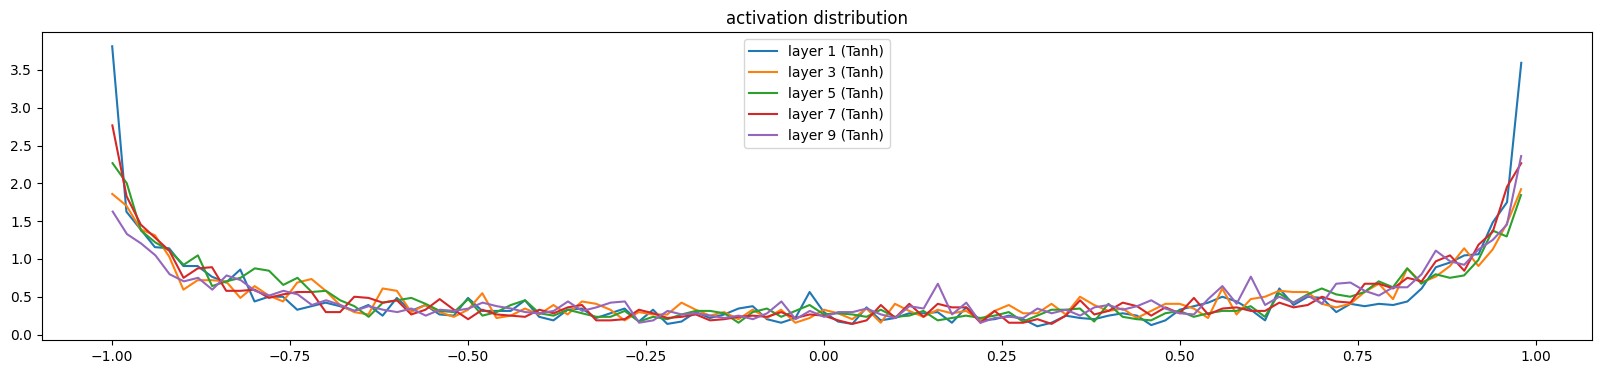

In [38]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    # Note: The following line is partially cut off in the image and has been completed based on context.
    print(f'layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    # Note: The following line is partially cut off in the image and has been completed based on context.
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

We can see in the above plot the values of the tanh in each layer of Tanh and we see that most of the values are not exterme towards either 0 or either 1, we can also modify the 5/3 that we are multiplying with above to may be 1, then we can see that the plot accumulates in the between at 0s, the 5/3 turns out to be a good number. And the reason we are adding the gain is we are dividing the weights by the square root of fan_in and it may cause the values to shrink to  0 as a converse effect so adding a gain will make the values to spread instead of getting conversed.

layer 1 (      Tanh): mean -0.000046, std 3.311777e-03
layer 3 (      Tanh): mean +0.000071, std 3.085905e-03
layer 5 (      Tanh): mean +0.000063, std 2.956750e-03
layer 7 (      Tanh): mean +0.000001, std 2.953025e-03
layer 9 (      Tanh): mean +0.000032, std 2.424185e-03


Text(0.5, 1.0, 'gradient distribution')

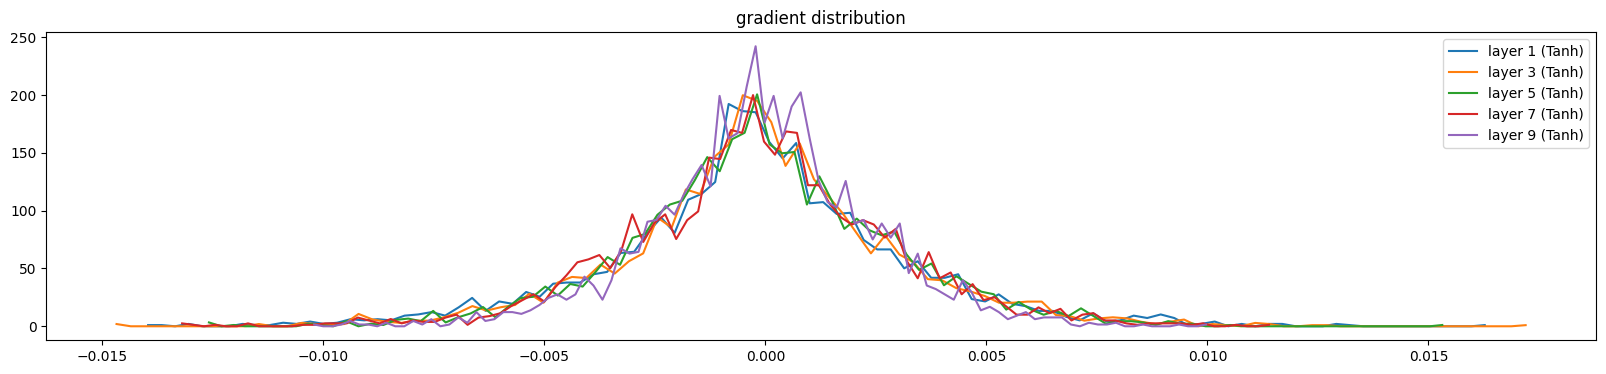

In [39]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    # Note: The following line is partially cut off in the image and has been completed based on context.
    print(f'layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    # Note: The following line is partially cut off in the image and has been completed based on context.
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution')

As we can see that this is a little bit tricky approach to make the neural net well behaved as we have to find the right gain for it.

And one more thing here to add is,why we use the Tanh() or acitvations like that and again we have to add gain at the last make sure the gradients aren't exploding and vanishing, if we don't use tanh or activations like that all these stacked up linear layers will turn into a big linear layer only, it will be just a linear function approximator but adding these activation functions allow the neural net to be an arbitary approximator of any function.

weight   (28, 10) | mean -0.000543 | std 1.082647e-02 | grad:data ratio 1.054615e-02
weight  (30, 100) | mean +0.000063 | std 1.110280e-02 | grad:data ratio 3.610690e-02
weight (100, 100) | mean -0.000083 | std 8.319802e-03 | grad:data ratio 4.927993e-02
weight (100, 100) | mean -0.000018 | std 7.419759e-03 | grad:data ratio 4.415174e-02
weight (100, 100) | mean -0.000009 | std 6.671548e-03 | grad:data ratio 3.958200e-02
weight (100, 100) | mean -0.000044 | std 6.300360e-03 | grad:data ratio 3.728540e-02
weight  (100, 28) | mean -0.000000 | std 2.293155e-02 | grad:data ratio 3.319160e-01


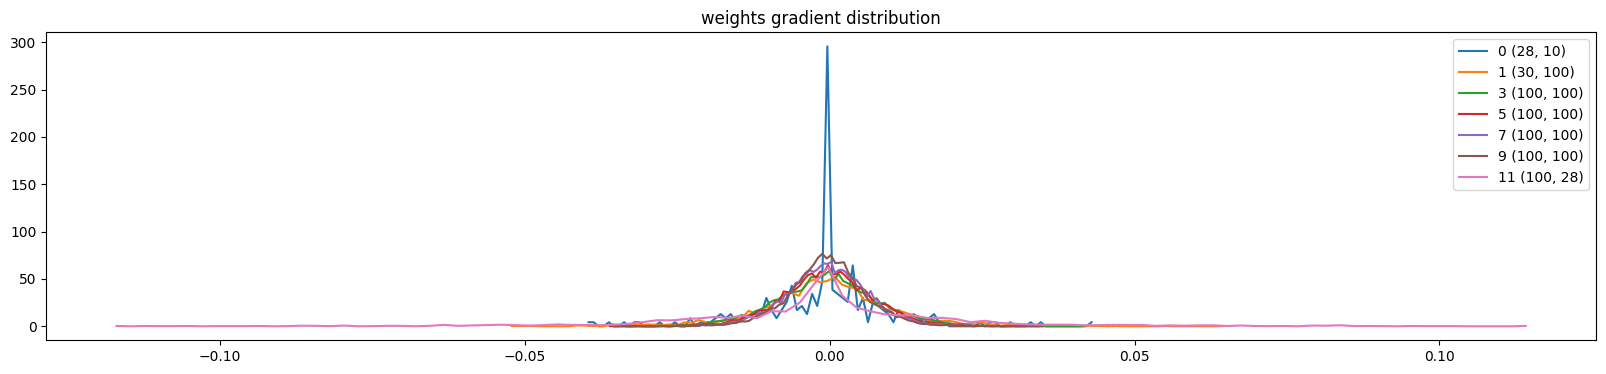

In [42]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2: # constraning to only consider the weights
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.data.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

In the above graph we are plotting he grad and data (only the weight params) ratio and for most of the layers the ratio is descent, the grad is a very small number when compared to the actual data but the last layer is not and if we look at the std of the last layer it is roughly 10 times higher than the other ones, so in stochastic gradient descent, the last layer will be trained 10 times faster when compared to the others atleast during the intialization, but this will fix itself it we train the net for a little bit longer, now we are logging for just a single iteration of the optimization

Instead of looking at the gradient to data ratio, what is helpful for us is to look at the update and the data ratio for that I am adding the ud var above to track it.

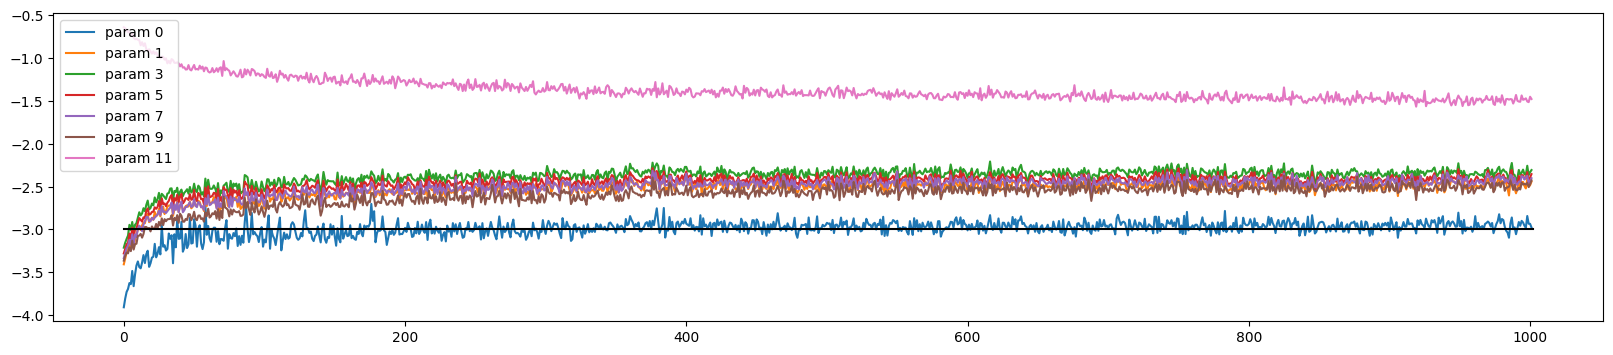

In [43]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

The param11 is looking like an outlier because we have reduced its confidence by multiplying with 0.1, it will stabilize onces it starts learning and we are also plotting 1e-3, if its below that line it means the parameters are not learning fast enought, try using a low learning rate and check.

Optimal Learning Rate 🚀: If this ratio is significantly higher than 1e-3, it suggests that the learning rate or updates are too large, potentially causing the model to overshoot the optimal solution.

Slow Learning 🐢: Conversely, if the ratio is much smaller than 1e-3, it indicates that the learning rate is likely too small, leading to very slow learning and potentially getting stuck in local minima.

This 1e-3 value serves as a diagnostic indicator to help determine if the learning rate is appropriately scaled for effective training of the neural network.

And this will also help us to adjust and update our learning rate.

And we can also by changing out intialization like removing the Kaiming multiplication, we can see that how our plots will be messed up, which indicates us that something is wrong in out neural net.

In [62]:
layers = [
    Linear(n_embd*block_size,n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,vocab_size), BatchNorm1d(vocab_size),
]
with torch.no_grad():
  # changing this to gamma because it the one that interact with the ouput
  layers[-1].gamma *= 0.1
  # all other layers : apply gain
  for layer in layers[:-1]:
    if isinstance(layer,Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) #  total number of parameters
for p in parameters:
  p.requires_grad = True


47664


In [63]:
# same optimization as last time

max_steps = 200_000
batch_size = 32
lossi= []
ud = []

for i in range(max_steps):

  # mini-batch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  x = emb.view(emb.shape[0],-1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x,Yb) # loss function


  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i%10000 == 0:
    print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
  lossi.append(loss.log10().item())

  with torch.no_grad():
    ud.append([(lr*p.grad.std() / p.data.std()).log10 ().item() for p in parameters ])

  if i > 1000:
    break

      0/ 200000:3.3127


layer 2 (      Tanh): mean -0.00, std 0.62, saturated: 3.31%
layer 5 (      Tanh): mean +0.01, std 0.63, saturated: 3.12%
layer 8 (      Tanh): mean +0.00, std 0.64, saturated: 2.19%
layer 11 (      Tanh): mean +0.01, std 0.64, saturated: 2.44%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.75%


Text(0.5, 1.0, 'activation distribution')

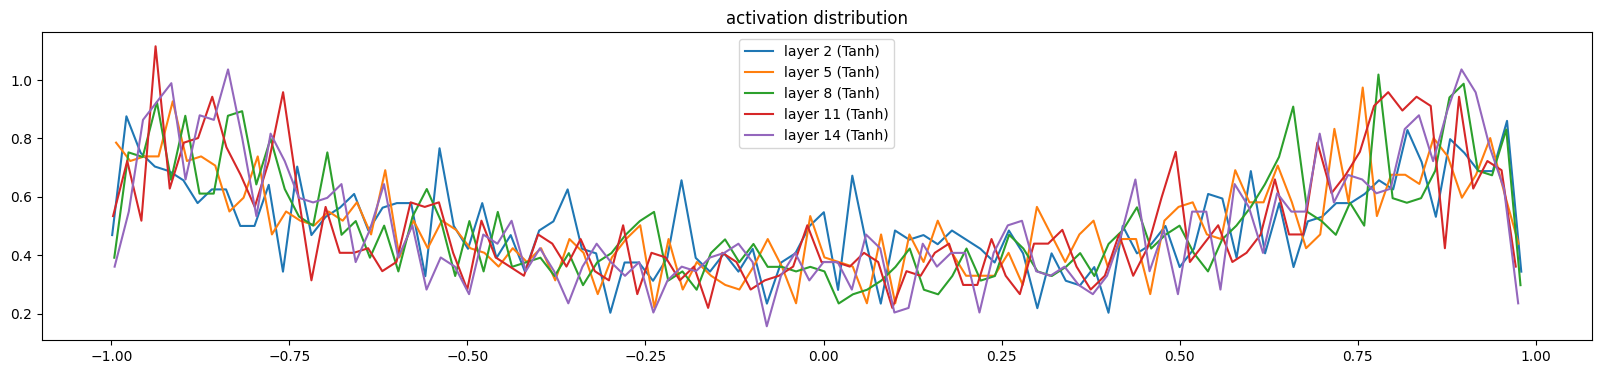

In [64]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    # Note: The following line is partially cut off in the image and has been completed based on context.
    print(f'layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    # Note: The following line is partially cut off in the image and has been completed based on context.
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.120167e-03
layer 5 (      Tanh): mean -0.000000, std 2.715351e-03
layer 8 (      Tanh): mean +0.000000, std 2.522843e-03
layer 11 (      Tanh): mean -0.000000, std 2.227682e-03
layer 14 (      Tanh): mean -0.000000, std 2.148606e-03


Text(0.5, 1.0, 'gradient distribution')

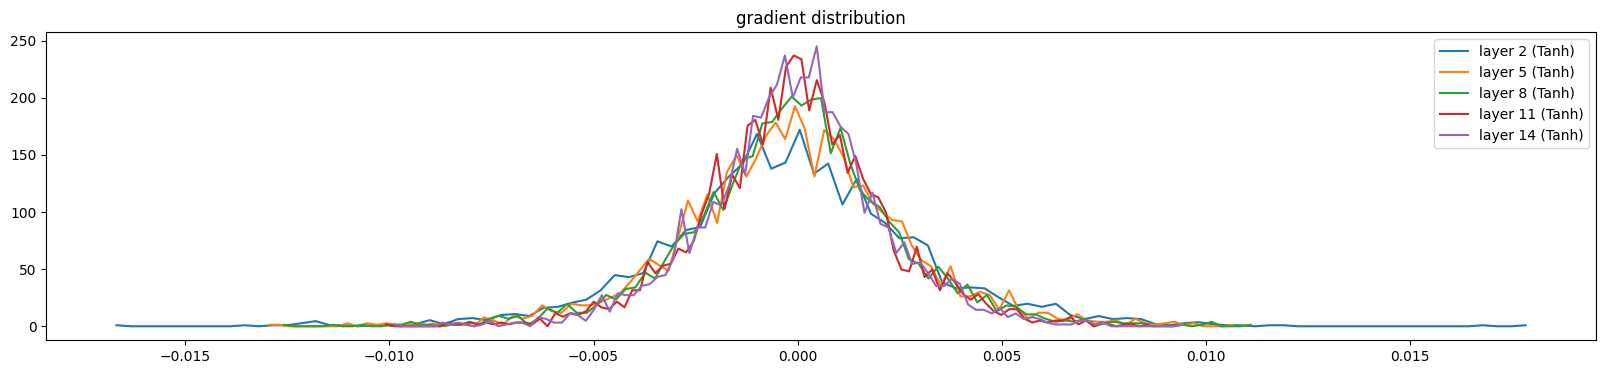

In [65]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    # Note: The following line is partially cut off in the image and has been completed based on context.
    print(f'layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    # Note: The following line is partially cut off in the image and has been completed based on context.
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution')

weight   (28, 10) | mean -0.000000 | std 9.031755e-03 | grad:data ratio 8.793801e-03
weight  (30, 100) | mean -0.000027 | std 7.239361e-03 | grad:data ratio 2.362331e-02
weight (100, 100) | mean -0.000017 | std 6.401915e-03 | grad:data ratio 3.797203e-02
weight (100, 100) | mean -0.000028 | std 5.818752e-03 | grad:data ratio 3.480276e-02
weight (100, 100) | mean -0.000061 | std 5.148449e-03 | grad:data ratio 3.078543e-02
weight (100, 100) | mean +0.000026 | std 4.461336e-03 | grad:data ratio 2.663875e-02
weight  (100, 28) | mean +0.000065 | std 7.769444e-03 | grad:data ratio 4.611819e-02


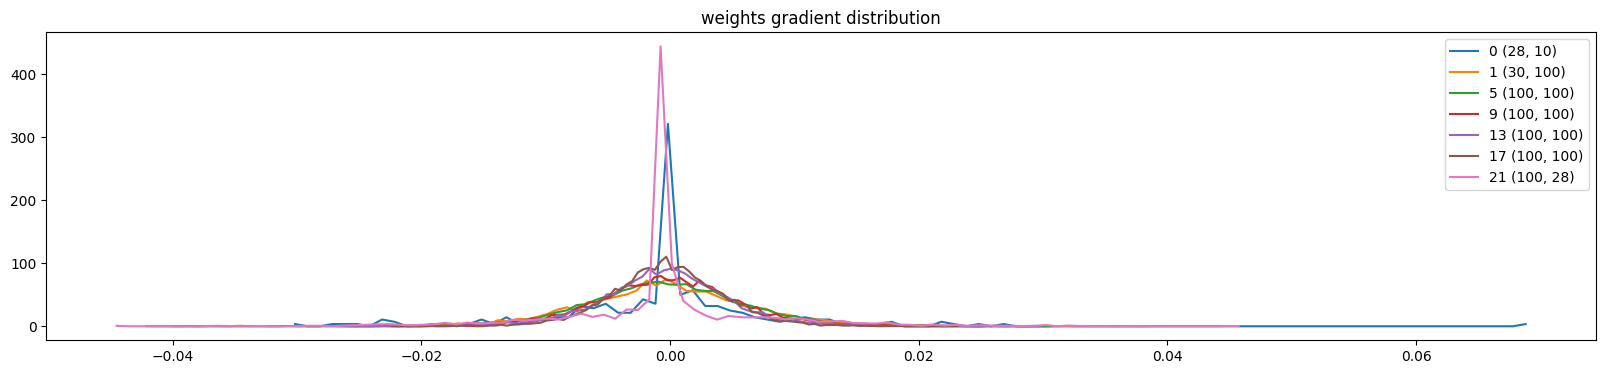

In [66]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2: # constraning to only consider the weights
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.data.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

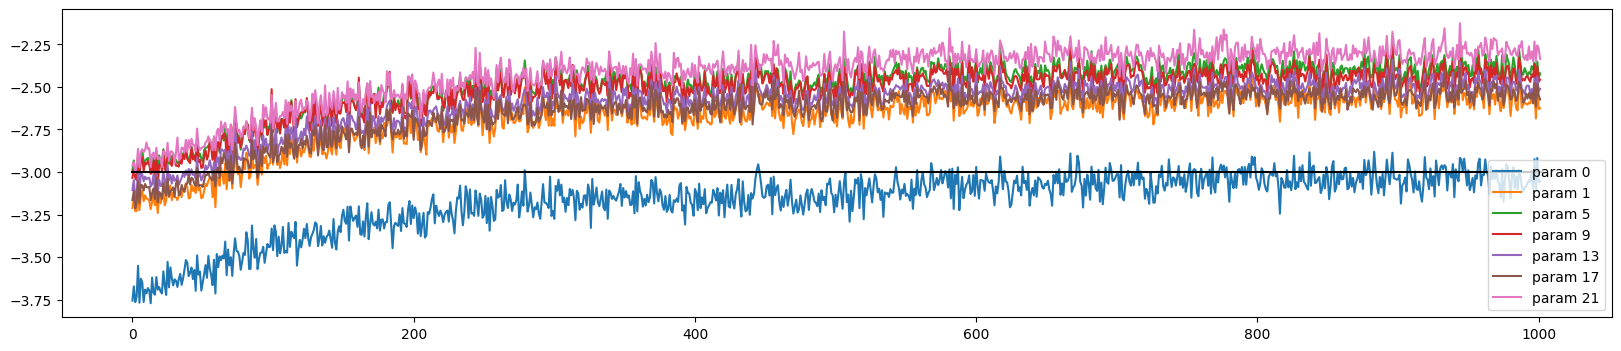

In [68]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

Since we are using Batch normalization we can remove the kaiming multiplication and the multiplication of 5/3 (gain), but after that we may need to adjust our learning rate by looking at the learning rate to the 1e-3 line.

In [87]:
# Let's train a deeper network

class Linear:

  def __init__ (self,fan_in,fan_out,bias=True):
    self.weight = torch.randn((fan_in,fan_out),generator=g) # / fan_in**0.5 # fixing the staturated tanh with the first method (Kaiming He)
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self,x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out+=self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

  def __init__(self, dim,eps=1e-5,momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters trained with backprop
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with running momentum update)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__ (self,x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else :
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x-xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma,self.beta]

class Tanh:
  def __call__ (self,x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(123) # for reproducibility

C = torch.randn((vocab_size,n_embd), generator=g)
layers = [
    Linear(n_embd*block_size,n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,vocab_size), BatchNorm1d(vocab_size),
]
with torch.no_grad():
  # changing this to gamma because it the one that interact with the ouput
  layers[-1].gamma *= 0.1
  # all other layers : apply gain
  for layer in layers[:-1]:
    if isinstance(layer,Linear):
      layer.weight *= 1.0 # removing the gain

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) #  total number of parameters
for p in parameters:
  p.requires_grad = True


47664


In [88]:
# same optimization as last time

max_steps = 200_000
batch_size = 32
lossi= []
ud = []

for i in range(max_steps):

  # mini-batch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  x = emb.view(emb.shape[0],-1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x,Yb) # loss function


  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 1.0 if i < 100000 else 0.01 # increasing the learning rate to 1
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i%10000 == 0:
    print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
  lossi.append(loss.log10().item())

  with torch.no_grad():
    ud.append([(lr*p.grad.std() / p.data.std()).log10 ().item() for p in parameters ])

  if i > 1000:
    break

      0/ 200000:3.3608


layer 2 (      Tanh): mean +0.01, std 0.63, saturated: 3.19%
layer 5 (      Tanh): mean -0.01, std 0.63, saturated: 3.75%
layer 8 (      Tanh): mean +0.01, std 0.63, saturated: 3.56%
layer 11 (      Tanh): mean -0.02, std 0.63, saturated: 2.88%
layer 14 (      Tanh): mean +0.00, std 0.64, saturated: 2.97%


Text(0.5, 1.0, 'activation distribution')

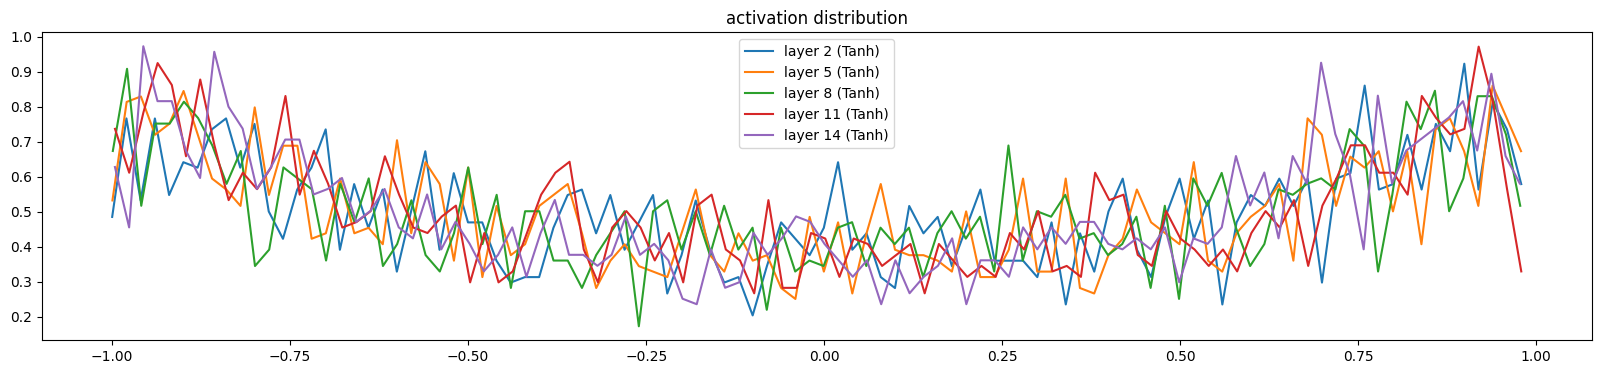

In [89]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    # Note: The following line is partially cut off in the image and has been completed based on context.
    print(f'layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    # Note: The following line is partially cut off in the image and has been completed based on context.
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 5.196608e-03
layer 5 (      Tanh): mean +0.000000, std 4.213724e-03
layer 8 (      Tanh): mean +0.000000, std 3.962833e-03
layer 11 (      Tanh): mean +0.000000, std 3.758565e-03
layer 14 (      Tanh): mean -0.000000, std 3.774462e-03


Text(0.5, 1.0, 'gradient distribution')

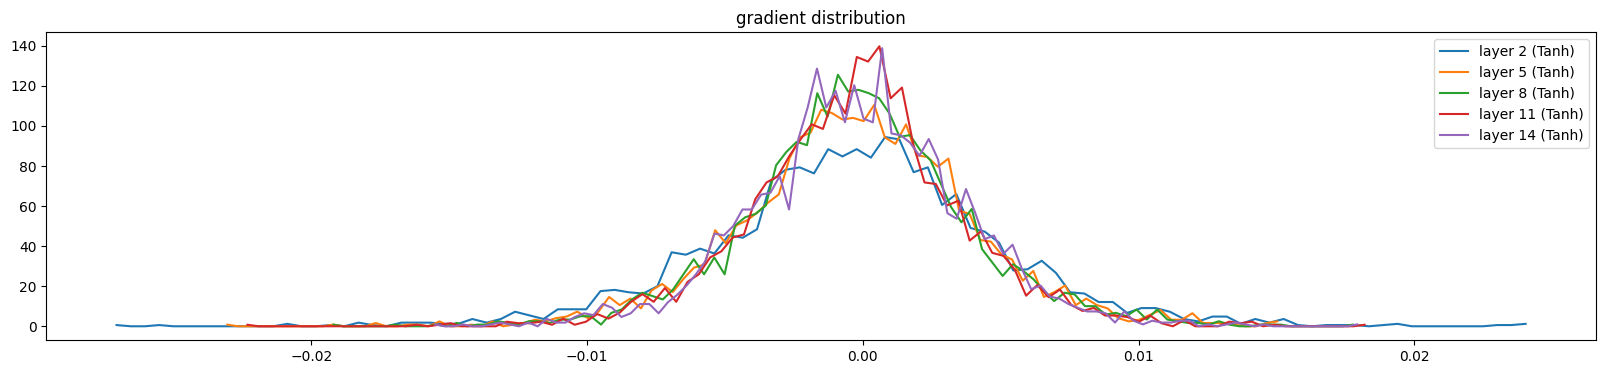

In [90]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    # Note: The following line is partially cut off in the image and has been completed based on context.
    print(f'layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    # Note: The following line is partially cut off in the image and has been completed based on context.
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution')

weight   (28, 10) | mean +0.000000 | std 1.182025e-02 | grad:data ratio 1.115119e-02
weight  (30, 100) | mean -0.000048 | std 3.886892e-03 | grad:data ratio 3.848878e-03
weight (100, 100) | mean -0.000012 | std 1.737866e-03 | grad:data ratio 1.735391e-03
weight (100, 100) | mean -0.000002 | std 1.473936e-03 | grad:data ratio 1.475969e-03
weight (100, 100) | mean +0.000014 | std 1.364750e-03 | grad:data ratio 1.360525e-03
weight (100, 100) | mean -0.000004 | std 1.320017e-03 | grad:data ratio 1.308615e-03
weight  (100, 28) | mean -0.000022 | std 2.721716e-03 | grad:data ratio 2.780620e-03


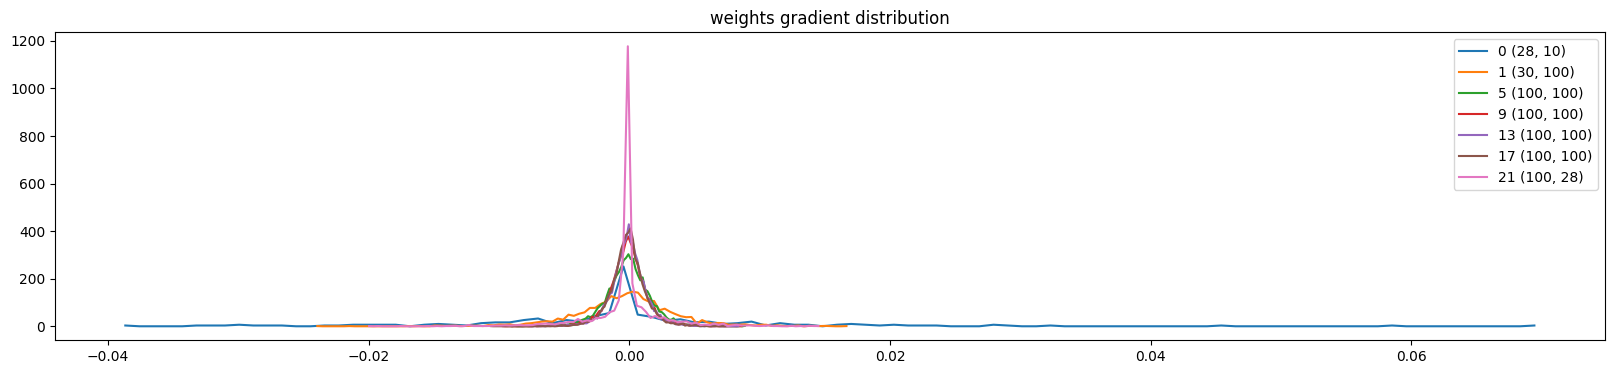

In [91]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2: # constraning to only consider the weights
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.data.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

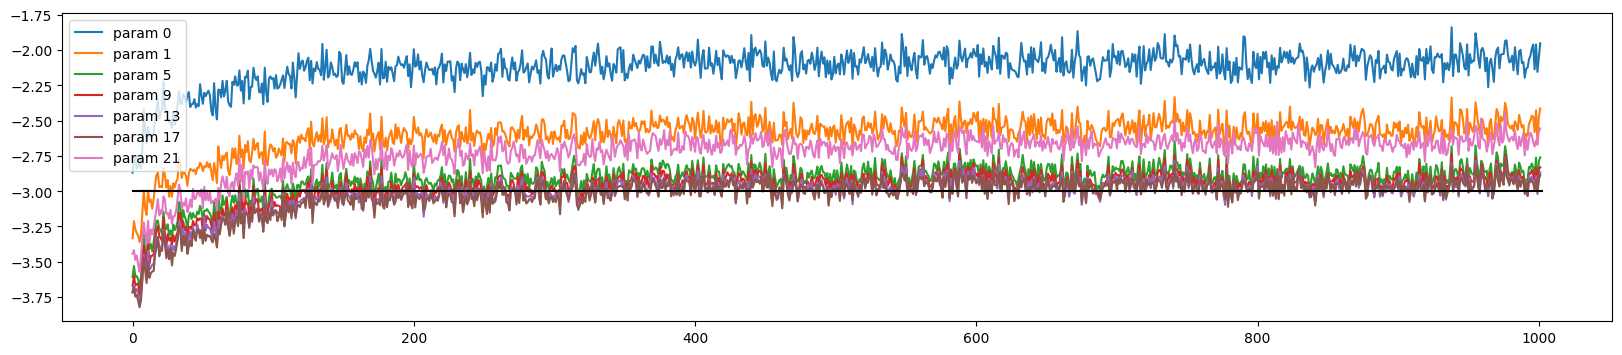

In [92]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);